# Objectif : Classification de sol par image satellite

# Partie Exploration de la donnée


La base de données contient les valeurs multispectrales des pixels d'une image satellite 3x3 pixels

## I. Compréhension du dataset



Notre dataset ne contient que des pixels de niveaux
de gris qui représentent les valeurs de réflectance des
surfaces au sol pour un intervalle de longueurs d’ondes
donné

Il y a 36 colonnes, chaque image satellite selectionnée pour le dataset fait 3*3 pixels. L'image est prise selon 4 intervalles de longueurs d'onde différentes (ce qu'on appelera par la suite bande spectrale) :
  - une proche du vert
  - une proche du rouge
  - deux proches des infrarouges 

Ces 4 variantes d'une seule image 3*3 pixels fournissent bien 36 valeurs au total



In [25]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from skimage.io import imshow # visualisation d'images satellite
import seaborn as sns

In [26]:
satellites_images = pd.read_csv("/content/sat_train.csv", sep=' ')
satellites_images

,92,115,120,94,84,102,106,79,84.1,102.1,102.2,83,101,126,133,103,92.1,112,118,85,84.2,103.1,104,81,102.3,126.1,134,104.1,88,121,128,100,84.3,107,113,87,3
0,84,102,106,79,84,102,102,83,80,102,102,79,92,112,118,85,84,103,104,81,84,99,104,78,88,121,128,100,84,107,113,87,84,99,104,79,3
1,84,102,102,83,80,102,102,79,84,94,102,79,84,103,104,81,84,99,104,78,84,99,104,81,84,107,113,87,84,99,104,79,84,99,104,79,3
2,80,102,102,79,84,94,102,79,80,94,98,76,84,99,104,78,84,99,104,81,76,99,104,81,84,99,104,79,84,99,104,79,84,103,104,79,3
3,84,94,102,79,80,94,98,76,80,102,102,79,84,99,104,81,76,99,104,81,76,99,108,85,84,99,104,79,84,103,104,79,79,107,109,87,3
4,80,94,98,76,80,102,102,79,76,102,102,79,76,99,104,81,76,99,108,85,76,103,118,88,84,103,104,79,79,107,109,87,79,107,109,87,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4429,56,64,108,96,64,71,108,96,68,75,108,96,59,75,109,96,67,87,113,96,67,95,109,92,63,79,108,92,66,83,108,96,66,87,104,89,5
4430,64,71,108,96,68,75,108,96,71,87,108,88,67,87,113,96,67,95,109,92,75,99,104,83,66,83,108,96,66,87,104,89,63,87,104,89,5
4431,68,75,108,96,71,87,108,88,71,91,100,81,67,95,109,92,75,99,104,83,75,95,100,79,66,87,104,89,63,87,104,89,70,100,104,85,4
4432,71,87,108,88,71,91,100,81,76,95,108,88,75,99,104,83,75,95,100,79,71,91,100,83,63,87,104,89,70,100,104,85,70,91,104,85,4


In [27]:
#Notre dataset ne contient que des int 
satellites_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4434 entries, 0 to 4433
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   92      4434 non-null   int64
 1   115     4434 non-null   int64
 2   120     4434 non-null   int64
 3   94      4434 non-null   int64
 4   84      4434 non-null   int64
 5   102     4434 non-null   int64
 6   106     4434 non-null   int64
 7   79      4434 non-null   int64
 8   84.1    4434 non-null   int64
 9   102.1   4434 non-null   int64
 10  102.2   4434 non-null   int64
 11  83      4434 non-null   int64
 12  101     4434 non-null   int64
 13  126     4434 non-null   int64
 14  133     4434 non-null   int64
 15  103     4434 non-null   int64
 16  92.1    4434 non-null   int64
 17  112     4434 non-null   int64
 18  118     4434 non-null   int64
 19  85      4434 non-null   int64
 20  84.2    4434 non-null   int64
 21  103.1   4434 non-null   int64
 22  104     4434 non-null   int64
 23  81      4434 

La dernière colonne indique l'étiquette de classification du pixel central

La classification permet de déterminer le type de sol 

Ce numéro compris entre 1 et 7 est un code pour les classes suivantes :

	Numéro de classe

	1 Terre rouge
	2 Culture du coton
	3 Sol gris
	4 Sol gris humide
	5 Sol avec des chaumes de végétation
	6 classe de mélange (tous les types présents)
	7 Sol gris très humide

  NB : Il n'y a pas d'exemples avec la classe 6 dans cette base de données

In [28]:
# On renomme les colonnes pour plus de clarté
satellites_images.columns =['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','Y'] 
satellites_images.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,Y
count,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.000000,4434.00000,4434.00000,4434.000000,4434.000000,4434.000000,4434.000000
mean,69.468877,83.848218,99.318223,82.553000,69.205458,83.495264,99.172982,82.481281,68.960081,83.126748,98.973162,82.414073,69.367614,83.722147,99.405277,82.649301,69.121561,83.427379,99.237709,82.617050,68.916554,83.140505,99.002706,82.479928,69.246955,83.661028,99.316870,82.669147,69.028868,83.425801,99.177267,82.63419,68.79364,83.147948,99.058412,82.583446,3.650429
std,13.646980,22.722826,16.671154,18.696768,13.552130,22.812689,16.629143,18.716309,13.497491,22.814124,16.678282,18.845387,13.650604,22.780050,16.682818,18.801801,13.558385,22.816232,16.725983,18.845985,13.465206,22.826415,16.721549,18.925899,13.640485,22.762664,16.695288,18.883735,13.532462,22.807683,16.737532,18.94016,13.43736,22.762433,16.661299,18.897527,2.217284
min,40.000000,27.000000,56.000000,33.000000,40.000000,27.000000,50.000000,29.000000,40.000000,27.000000,50.000000,29.000000,40.000000,27.000000,53.000000,33.000000,40.000000,27.000000,56.000000,34.000000,39.000000,27.000000,50.000000,29.000000,40.000000,27.000000,53.000000,34.000000,39.000000,27.000000,50.000000,29.00000,40.00000,27.000000,50.000000,29.000000,1.000000
25%,60.000000,71.000000,85.000000,70.000000,60.000000,71.000000,85.000000,69.000000,60.000000,71.000000,85.000000,68.000000,60.000000,71.000000,85.000000,69.250000,60.000000,71.000000,85.000000,69.000000,60.000000,71.000000,85.000000,68.000000,60.000000,71.000000,85.000000,70.000000,60.000000,71.000000,85.000000,69.00000,60.00000,71.000000,85.000000,69.000000,2.000000
50%,68.000000,87.000000,101.000000,83.000000,68.000000,85.000000,101.000000,81.000000,67.000000,85.000000,101.000000,81.000000,68.000000,87.000000,101.000000,81.000000,68.000000,85.000000,101.000000,81.000000,67.000000,85.000000,100.000000,81.000000,68.000000,85.000000,101.000000,81.000000,68.000000,85.000000,101.000000,81.00000,67.00000,85.000000,100.000000,81.000000,3.000000
75%,80.000000,103.000000,113.000000,92.000000,80.000000,103.000000,113.000000,92.000000,79.000000,103.000000,113.000000,92.000000,80.000000,103.000000,113.000000,92.000000,79.000000,103.000000,113.000000,92.000000,79.000000,103.000000,113.000000,92.000000,80.000000,103.000000,113.000000,92.000000,79.000000,103.000000,113.000000,92.00000,79.00000,103.000000,113.000000,92.000000,5.000000
max,104.000000,137.000000,140.000000,154.000000,102.000000,137.000000,145.000000,157.000000,104.000000,130.000000,145.000000,157.000000,102.000000,131.000000,145.000000,151.000000,104.000000,130.000000,139.000000,157.000000,104.000000,130.000000,140.000000,154.000000,104.000000,131.000000,140.000000,154.000000,104.000000,128.000000,145.000000,157.00000,104.00000,130.000000,145.000000,157.000000,7.000000


La valeur minimum d'un pixel sur la totalité des colonnes est de 27 et la valeur maximum est de 157. 

Les pixels pouvant varier de 0 (noir) à 255 (blanc), on comprend alors que les images satellites représentent les valeurs de réflectance des surfaces visant le sol. 
Ainsi, pas d'image dans le vide ni d'image trop proche pouvant donner des extrêmes.



## II. Vérification de la cohérence du dataset

Sur la page *Comprendre une image satellitaire* sur le site CMS GéoBretagne, on obtient cette information : 

```
Dans l'intervalle de longueur d'onde correspondant aux couleurs vertes et rouges, la végétation a des valeurs de réflectance basses, 
alors qu'elle a des valeurs élevées dans l'intervalle des longueurs d'onde de l'infrarouge.
```
Source: https://cms.geobretagne.fr/sites/default/files/documents/fiches_2_comprendre_une_image_satellitaire_1.pdf page 6/10

.


Nous allons donc regarder s'il existe une corrélation entre la *classe 5 : Sol avec des chaumes de végétation* et les niveaux de réfletance associés


In [29]:
# On créé un dataframe avec seulement les images qui ont été classées comme sol avec des chaumes de végétation
df_vegetation = satellites_images[satellites_images.Y == 5]
#type(df_vegetation)

Dans la documentation du dataset, on peut lire 

```
Pour chaque ligne du dataframe, les quatre valeurs 
spectrales pour le pixel supérieur gauche sont données en 
premier, suivies des quatre valeurs spectrales pour le 
pixel supérieur moyen et ensuite de celles pour le pixel 
supérieur droit, et ainsi de suite avec les pixels lus en 
séquence de gauche à droite et de haut en bas.

```
Autrement dit, pour reformer une image 3*3 pixels d'une même bande spectrale, en premier celle proche du vert, il faut la valeur de la colonne '1' puis '5' puis '9', '13', '17', '21', '25', '29' et enfin '33'. 





In [30]:
col1 = []
for i in range(1,37,4):
    i = str(i)
    col1.append(i)  
#print(col1)

df1 = df_vegetation.loc[:,col1]
print(df1)

       1   5   9  13  17  21  25  29  33
42    80  76  68  80  71  60  79  79  75
43    76  68  60  71  60  56  79  75  75
44    60  64  80  56  71  80  75  84  84
49    68  64  57  68  60  53  67  59  55
50    64  57  53  60  53  53  59  55  55
...   ..  ..  ..  ..  ..  ..  ..  ..  ..
4426  56  53  56  59  59  59  59  63  59
4427  53  56  60  59  59  63  63  59  59
4428  60  56  64  63  59  67  59  63  66
4429  56  64  68  59  67  67  63  66  66
4430  64  68  71  67  67  75  66  66  63

[470 rows x 9 columns]


On construit de même le dataframe df2 qui correspond aux images associées à la bande spectrale proche du rouge

In [31]:
col2 = []
for i in range(2,37,4):
    i = str(i)
    col2.append(i)  

df2 = df_vegetation.loc[:,col2]
#print(df2)

df3 et df4 correspondent aux bandes spectrales proches de l'infrarouge

In [32]:
col3 = []
for i in range(3,37,4):
    i = str(i)
    col3.append(i)  

df3 = df_vegetation.loc[:,col3]
#print(df3)

In [33]:
col4 = []
for i in range(4,37,4):
    i = str(i)
    col4.append(i)  

df4 = df_vegetation.loc[:,col4]
#print(df4)

On veut vérifier, maintenant que les images sont séparées par bandes spectrales, que df1 et df2 ont des valeurs de reflectance basses et que df3 et df4 ont des valeurs de reflectance élevées. 

In [34]:
#Le pixel moyen de la classe végétation vaut 67
avg_general = df_vegetation.mean()
avg_general = avg_general.mean()
print(avg_general)

67.78999424956871


In [35]:
avg1 = df1.mean().mean()
avg2 = df2.mean().mean()

print(avg1,avg2)

60.232624113475175 63.43191489361701


In [36]:
avg3 = df3.mean().mean()
avg4 = df4.mean().mean()

print(avg3,avg4)

83.80141843971631 70.67068557919622


In [37]:
#Variation de la reflectance sur la bande spectrale rouge 
var1 = int(((avg1-avg_general)/avg_general)*100)
#Variation de la reflectance sur la bande spectrale verte
var2 = int(((avg2-avg_general)/avg_general)*100)
#Variation de la reflectance sur la bande spectrale infra-rouge 1
var3 = int(((avg3-avg_general)/avg_general)*100)
#Variation de la reflectance sur la bande spectrale infra-rouge 2
var4 = int(((avg4-avg_general)/avg_general)*100)
print(var1, var2, var3, var4)

-11 -6 23 4


In [38]:
#x = np.array(list("1234"))
x= ["Proche vert", "Proche rouge", "Proche infrarouge", "Proche infrarouge 2"]
y1 = [var1, var2, var3, var4]

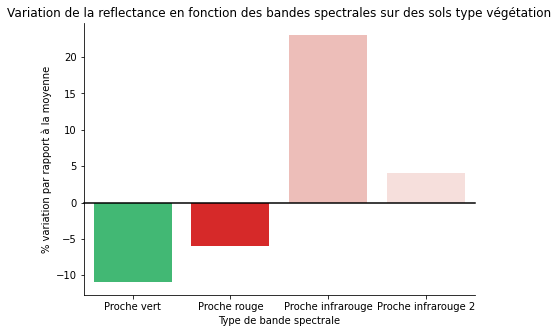

In [40]:
# Set up the matplotlib figure
f, (ax) = plt.subplots(1, 1, figsize=(7, 5), sharex=True)

# Create an array with the colors you want to use
colors = ["#2ECC71","#F30C0C", "#F5B7B1", "#FADBD8"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

sns.barplot(x=x, y=y1, palette=colors, ax=ax)
ax.axhline(0, color="k", clip_on=False)
ax.set_ylabel("Diverging")

# Customize the axes and title
ax.set_title("Variation de la reflectance en fonction des bandes spectrales sur des sols type végétation")
ax.set_xlabel("Type de bande spectrale")
ax.set_ylabel("% variation par rapport à la moyenne")

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.show()

Ce résultat vérifie bien l'hypothèse énoncée par le site CMS - GéoBretagne. 

Pour un sol avec de la végétation comme la classe 5 : sol avec des chaumes de végétation, on obtient des valeurs de réfléctances basses pour les bandes spectrales proches du vert et du rouge et des valeurs élevées pour des bandes spectrales proche de l'infrarouge.

Il y a bien une cohérence entre le type de sol photographié et sa reflectance.  

## III. Affichage des quatre variantes d'image

In [ ]:
p1 = df1.loc[42].values
p2 = df2.loc[42].values
p3 = df3.loc[42].values
p4 = df4.loc[42].values

# Réorganisation des données en trois colonnes
img1 = p1.reshape(3,3)
img2 = p2.reshape(3,3)
img3 = p3.reshape(3,3)
img4 = p4.reshape(3,3)

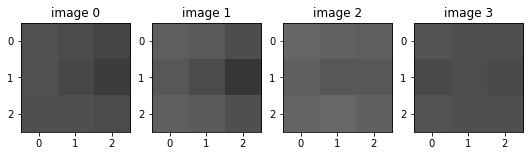

In [ ]:
w = 10
h = 10
fig = plt.figure(figsize=(9, 13))
columns = 4
rows = 1

# ax enables access to manipulate each of subplots
ax = []
dico = { 1: img1, 2: img2, 3: img3, 4: img4}

for i in range(columns*rows):
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("image "+str(i))  # set title
    plt.imshow(dico[i+1], cmap='gray', vmin=0, vmax=255)

Sur un même sol, les quatre images sont différentes dûes à leur différence de bande spectrale.

# Partie-Machine-Learning

In [41]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow        as tf
from tensorflow              import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors
from sklearn import svm
from sklearn import neighbors

## I. Préparation des données

In [ ]:
#Importation des fichiers de train et de tests
satellites_images_train = pd.read_csv("sat_train.csv", sep=' ')
satellites_images_test = pd.read_csv("sat_test.csv", sep=' ')

#Création des colonnes
satellites_images_train.columns =['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','Y'] 
satellites_images_test.columns =['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','Y'] 

In [ ]:
#Affichage du nombres de lignes dans chaque fichier
print("Nombre de lignes dans le train set : " + str(satellites_images_train.shape[0]))
print("Nombre de lignes dans le test set : " + str(satellites_images_test.shape[0]))

In [ ]:
#Séparation des valeurs d'entrées et de sorties dans nos 2 fichiers
x_train = satellites_images_train.iloc[:,0:-1]
y_train = satellites_images_train.iloc[:,-1:]

x_test = satellites_images_test.iloc[:,0:-1]
y_test = satellites_images_test.iloc[:,-1:]

#Normalisation des valeurs d'entrées
x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0

## II. Utilisation de tensorflow

In [ ]:
# Utilisation de tensorflow pour déterminer un modele
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(36,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#On entraine notre modele tensorflow
model.fit(x_train_normalized, y_train, epochs=100,batch_size=500)

In [ ]:

test_loss, test_acc = model.evaluate(x_test_normalized, y_test, verbose=2)

# Affichage de l'accuracy de notre model avec notre jeu de test
print('Accuracy de notre modele sur notre jeu de test:', test_acc)

In [ ]:
# Résultat des prédictions sur notre fichier de tests
predictions = model.predict(x_test_normalized)

In [ ]:
#Prédiction de notre premiere ligne
predictions[0]

In [ ]:
class_names = ['red soil', 'cotton crop', 'grey soil', 'damp grey soil', 'soil with vegetation stubble',
               'mixture class (all types present)', 'very damp grey soil']

## III. Utilisation de Nearest Neighbors (KNN)

In [ ]:
# Determinination des meilleurs paramètres pour KNN
from sklearn.neighbors import KNeighborsClassifier
score_max = 0
best_n_neighbors = 0
for i in range(1,36) :
    KNN = KNeighborsClassifier(n_neighbors=i, algorithm='auto')
    model = KNN.fit(x_train, y_train)
    score = model.score(x_test,y_test)
    if score > score_max :
        score_max = score
        best_n_neighbors = i
 
#Affichage du best score avec les meilleurs paramètres :
print("score max : " + str(score_max) + " avec n_neighbors = " + str(i))

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=35, algorithm='auto')
KNN_model = KNN.fit(x_train, y_train)

# Determination du pourcentage de certitude
row = 12
class_names = ['red soil', 'cotton crop', 'grey soil', 'damp grey soil', 'soil with vegetation stubble',
                'very damp grey soil','truc']

predict_proba = KNN_model.predict_proba(x_test[row-1:row])
print("Pourcentage de certitude pour la ligne " + str(row) + " :" )
for i in range(6) :
    print("    Pour " + class_names[i] + " : " + str(predict_proba[0,i]*100) + "%")

## IV. Utilisation de SVM

In [ ]:
def svm_grid_search(df, Y):
    """
    Réglage des hyper-paramètres du classifieur Support Vector Machine
    Notamment : 'C', 'kernel' et 'gamma'
    """
    import sys
    from sklearn.model_selection   import GridSearchCV
    from sklearn.svm               import SVC
    import pickle
    parameters = {  "C"              : [1.0, 0.5,0.1],# 2]                , 
                    "kernel"         : ['rbf', 'poly', 'sigmoid'],#        ,
                    "degree"         : [2],# , 3, 4,5,6                    , 
                    "gamma"          : [0.01],#, 0.1, 0.001, 0.5]           , 
                    "coef0"          : [0.0]                             , 
                    "shrinking"      : [True]                            , 
                    "probability"    : [True,False]                            , 
                    "tol"            : [0.001]                           , 
                    "cache_size"     : [10]                              , 
                    "class_weight"   : [None]                            , 
                    "verbose"        : [False]                           , 
                    "max_iter"       : [-1]                              , 
                    "random_state"   : [None]                            }
   
    
    
    print ("-"*30, "\n svm_grid_search"); sys.stdout.flush()
    
    """
        Search Grid
    """
    grid    = GridSearchCV(SVC(), parameters, verbose=0, scoring='f1_weighted')
    try :grid.fit(df, Y)
    except Exception as e : 
        print ("[svm_grid_search - 2] : %s"%e) ; 
        print ("x_train,  y_train : ", x_train, y_train)

    print (" best_score_ = %.2f with =  %s "%(grid.best_score_, grid.best_estimator_ ) ); sys.stdout.flush()    
    
    cv_results = pd.DataFrame(grid.cv_results_)
    print(cv_results.iloc[grid.best_index_])
    
    return grid.best_estimator_

In [ ]:
#Determination du meilleur algorithme pour SVM

svm = svm_grid_search(x_train,y_train.values)

In [ ]:
SVN = svm.SVC(decision_function_shape='ovo')
SVN_model = SVN.fit(x_train,y_train)
SVN_score = SVN_model.score(x_test,y_test)
print("Score du classifier Support Vector Machine :", SVN_score)

## V. Utilisation de Naive Bayers Classifier

In [ ]:
algo   = GaussianNB()
modele = algo.fit(x_train, y_train)
score = modele.score(x_test, y_test)
print("Accuracy de notre model GaussianNB sur notre jeu de test : " + str(score))

# API Django

## Création du fichier pickle pour l'API Django

In [ ]:
#On choisi le modèle que l'on souhaite utiliser
#On choisi KNN car c'est celui qui a eu le plus haut accuracy
KNN = KNeighborsClassifier(n_neighbors=35, algorithm='auto')
KNN_model = KNN.fit(x_train, y_train)

In [ ]:
import pickle
pickle.dump(KNN_model, open('final_prediction.pickle', 'wb'))

In [ ]:
# Lancer la cellule une fois l'environnement Flask lancé
import requests
import json

url = 'http://localhost:5000/api/'

data = [[80, 102, 102, 79, 76, 102, 102, 79, 76, 102, 106, 83, 76, 99, 108, 85, 76, 103, 118, 88, 80, 107, 118, 88, 79, 107, 109, 87, 79, 107, 109, 87, 79, 107, 113, 87,]]
j_data = json.dumps(data)
headers = {'content-type': 'application/json', 'Accept-Charset': 'UTF-8'}
r = requests.post(url, data=j_data, headers=headers)
print(r, r.text)